### 本文档解决的问题是：
### 不同分布地点的加工厂分别与什么变量的关系更大
### 首先通过相关性分析去掉共线变量

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box,Polygon
from shapely.geometry import box
import analysis_tool as tool

In [8]:
gdfs = tool.load_all_gdfs("origin_data")

✅  已加载 00_Boundaries: Whole area.shp (1 条记录, 0.08 MB)
✅  已加载 01_production_farming: farming.shp (1647 条记录, 2.90 MB)
✅  已加载 02_production_aquaculture: aquaculture.shp (211 条记录, 2.49 MB)
✅  已加载 03_production_livestock: livestock.shp (1538 条记录, 1.61 MB)
✅  已加载 04_transformation_industry: processing.shp (58 条记录, 0.00 MB)
✅  已加载 05_transformation_energy: energy.shp (147 条记录, 0.03 MB)
✅  已加载 06_logistics_transportation: transportation.shp (656 条记录, 0.28 MB)
✅  已加载 07_logistics_roads: roads_highways.shp (58252 条记录, 6.92 MB)
✅  已加载 08_supply_retail: shop_food_beverage_data.shp (432 条记录, 0.01 MB)
✅  已加载 09_supply_public_services: public_services.shp (911 条记录, 0.02 MB)
✅  已加载 10_built_environment: buildings.shp (189600 条记录, 54.22 MB)
✅  已加载 11_consumption_facilities: consumption_data.shp (2889 条记录, 0.08 MB)
✅  已加载 12_consumption_landuse_mix: landuse_mix.shp (7124 条记录, 2.28 MB)
✅  已加载 13_waste_treatment: impianti_smaltimento_rifiuti.shp (10 条记录, 0.00 MB)


In [10]:
def create_square_patch(center_point, half_size):
    x, y = center_point.x, center_point.y
    return box(x - half_size, y - half_size, x + half_size, y + half_size)

# 创建 patch GeoDataFrame
patch_size = 500  # 半径500m → patch大小为1000m×1000m
patches = gdfs["04_transformation_industry"].copy()
patches["geometry"] = patches.geometry.apply(lambda pt: create_square_patch(pt, patch_size))
patches.reset_index(drop=True, inplace=True)
print(patches)
patches.to_file("processing_data\patch\patches_1000.geojson")

                                           DENOMINAZI                 Type  \
0                              ADRIAGEL ITALIA S.R.L.    Pasta&baked goods   
1                                      Alla Vaccheria                Dairy   
2                                Apicoltura Api Piave  Fruits & Vegetables   
3                                 Apicoltura G di ape  Fruits & Vegetables   
4                            APICOLTURA Miele e Pappa  Fruits & Vegetables   
5                                Apicoltura Montagner  Fruits & Vegetables   
6                                    Az. Agr. Corradi  Fruits & Vegetables   
7            Az.Agr. Vignaluna Di Lunardelli Giovanni               Winery   
8                              Azienda agricola Basso  Fruits & Vegetables   
9            Azienda Agricola Biodinamica San Michele                Dairy   
10                        Azienda Agricola Castellana  Fruits & Vegetables   
11                    Azienda Agricola Gianni Dartora  Fruits & 

In [11]:
# 空间连接，储存为 joined_patches
grid = gpd.read_file("processing_data\patch\patches_1000.geojson")
# 计算面
grid = tool.area_polygons_in_grid(gdfs["01_production_farming"], grid, "farming_area")
grid = tool.area_polygons_in_grid(gdfs["02_production_aquaculture"], grid, "aquaculture_area")
grid = tool.area_polygons_in_grid(gdfs["03_production_livestock"], grid, "pasture_area")
grid = tool.area_polygons_in_grid(gdfs["05_transformation_energy"], grid, "energy_area")
grid = tool.area_polygons_in_grid(gdfs["06_logistics_transportation"], grid, "transportation_area")
grid = tool.area_polygons_in_grid(gdfs["10_built_environment"], grid, "built_area")
grid = tool.area_polygons_in_grid(gdfs["12_consumption_landuse_mix"], grid, "landuse_area")

# 计算各个landuse
gdf_landuse=gdfs["12_consumption_landuse_mix"]
landuse_types = gdf_landuse["landuse"].unique()
for landuse_type in landuse_types:
    sub_gdf = gdf_landuse[gdf_landuse["landuse"] == landuse_type]
    column_name = f"{landuse_type}_area"
    grid = tool.area_polygons_in_grid(sub_gdf, grid, column_name)
# 计算点
# grid = tool.count_points_in_grid(gdfs["04_transformation_industry"], grid, "factory_count")
grid = tool.count_points_in_grid(gdfs["08_supply_retail"], grid, "retail_count")
grid = tool.count_points_in_grid(gdfs["09_supply_public_services"], grid, "public_services")
grid = tool.count_points_in_grid(gdfs["11_consumption_facilities"], grid, "consumption_count")
grid = tool.count_points_in_grid(gdfs["13_waste_treatment"], grid, "waste_treatment")

# 计算线
grid = tool.length_lines_in_grid(gdfs["07_logistics_roads"], grid, "road_length")

# 道路交叉点
gdf_intersections = tool.extract_road_intersections(gdfs["07_logistics_roads"])
grid = tool.count_points_in_grid(gdf_intersections, grid, "intersection_count")
# 其他
grid.to_file("processing_data\patch\joined_patches_1000.geojson")

  Calculating area for farming_area...


100%|██████████| 1686/1686 [00:00<00:00, 25698.73it/s]


  Calculating area for aquaculture_area...


100%|██████████| 227/227 [00:00<00:00, 6964.63it/s]


  Calculating area for pasture_area...


100%|██████████| 1556/1556 [00:00<00:00, 40079.94it/s]


  Calculating area for energy_area...


100%|██████████| 147/147 [00:00<00:00, 11049.71it/s]


  Calculating area for transportation_area...


100%|██████████| 656/656 [00:00<?, ?it/s]


  Calculating area for built_area...


100%|██████████| 192718/192718 [00:03<00:00, 58778.22it/s]


  Calculating area for landuse_area...


100%|██████████| 7211/7211 [00:00<00:00, 50127.58it/s]
g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  Calculating area for farmland_area...


100%|██████████| 4430/4430 [00:00<00:00, 52584.60it/s]
g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  Calculating area for meadow_area...


100%|██████████| 219/219 [00:00<00:00, 29188.20it/s]
g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  Calculating area for residential_area...


100%|██████████| 1899/1899 [00:00<00:00, 49563.68it/s]
g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  Calculating area for industrial_area...


100%|██████████| 301/301 [00:00<00:00, 18467.38it/s]
g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  Calculating area for commercial_area...


100%|██████████| 98/98 [00:00<00:00, 24503.24it/s]
g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  Calculating area for retail_area...


100%|██████████| 88/88 [00:00<00:00, 7973.62it/s]
g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  Calculating area for construction_area...


100%|██████████| 159/159 [00:00<00:00, 38689.70it/s]
g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  Calculating area for recreation_ground_area...


100%|██████████| 13/13 [00:00<?, ?it/s]
g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


  Calculating area for education_area...


100%|██████████| 4/4 [00:00<00:00, 3999.34it/s]


 Counting points for retail_count...
 Counting points for public_services...
 Counting points for consumption_count...
 Counting points for waste_treatment...
  Calculating total line length for road_length...


提取交叉口: 100%|██████████| 58252/58252 [00:12<00:00, 4679.78it/s]


 Counting points for intersection_count...


In [12]:
# 归一化，存储成
from sklearn.preprocessing import MinMaxScaler
import numpy as np


joined_grid= gpd.read_file("processing_data\patch\joined_patches_1000.geojson")

cols_to_normalize = [
       'farming_area', 'pasture_area', 'energy_area',
       'transportation_area', 'landuse_area', 'farmland_area',
       'meadow_area', 'residential_area', 'industrial_area', 'commercial_area',
       'retail_area', 'construction_area', 'recreation_ground_area',
       'education_area', 'retail_count', 'public_services',
       'consumption_count', 'waste_treatment', 'road_length',
       'intersection_count', 'aquaculture_area', 'built_area'
]
# 归一化
scaler = MinMaxScaler()
grid[[f"{col}_norm" for col in cols_to_normalize]] = scaler.fit_transform(joined_grid[cols_to_normalize])

# 计算农业混合度
production_cols = ['farming_area','aquaculture_area','pasture_area']
norm_cols = [f"{col}_norm" for col in production_cols]
def shannon_entropy_production(row):
    p = row[norm_cols].values
    p = np.array(p, dtype=float)
    if p.sum() == 0:
        return 0
    p = p / p.sum()
    return -np.nansum(p * np.log2(p + 1e-9))
grid['entropy_production'] = grid.apply(shannon_entropy_production, axis=1)

# 计算用地混合度
landuse_cols = ['farmland_area',
       'meadow_area', 'residential_area', 'industrial_area', 'commercial_area',
       'retail_area', 'construction_area', 'recreation_ground_area',
       'education_area']
norm_cols_2 = [f"{col}_norm" for col in landuse_cols]
def shannon_entropy_landuse(row):
    p = row[norm_cols_2].values
    p = np.array(p, dtype=float)
    if p.sum() == 0:
        return 0
    p = p / p.sum()
    return -np.nansum(p * np.log2(p + 1e-9))
grid['entropy_landuse'] = grid.apply(shannon_entropy_landuse, axis=1)
print(grid.columns)
# grid = grid[['grid_id','geometry', 'farming_area_norm','aquaculture_area_norm',
#        'pasture_area_norm', 'energy_area_norm', 'transportation_area_norm',
#        'factory_count_norm', 'retail_count_norm', 'public_services_norm',
#        'consumption_count_norm', 'waste_treatment_norm', 'road_length_norm',
#        'intersection_count_norm','built_area_norm',
#        'entropy_production', 'entropy_landuse' ]]
grid = grid[['geometry', 'farming_area_norm','aquaculture_area_norm',
       'pasture_area_norm', 'energy_area_norm', 'transportation_area_norm',
       'retail_count_norm', 'public_services_norm',
       'consumption_count_norm', 'waste_treatment_norm', 'road_length_norm',
       'intersection_count_norm','built_area_norm',
       'entropy_production', 'entropy_landuse' ]]
grid.to_file("processing_data\patch\patches_normalized_1000.geojson")

Index(['DENOMINAZI', 'Type', 'geometry_w', 'Unnamed_ 4', 'lat', 'lon',
       'geometry', 'farming_area', 'aquaculture_area', 'pasture_area',
       'energy_area', 'transportation_area', 'built_area', 'landuse_area',
       'farmland_area', 'meadow_area', 'residential_area', 'industrial_area',
       'commercial_area', 'retail_area', 'construction_area',
       'recreation_ground_area', 'education_area', 'retail_count',
       'public_services', 'consumption_count', 'waste_treatment',
       'road_length', 'intersection_count', 'farming_area_norm',
       'pasture_area_norm', 'energy_area_norm', 'transportation_area_norm',
       'landuse_area_norm', 'farmland_area_norm', 'meadow_area_norm',
       'residential_area_norm', 'industrial_area_norm', 'commercial_area_norm',
       'retail_area_norm', 'construction_area_norm',
       'recreation_ground_area_norm', 'education_area_norm',
       'retail_count_norm', 'public_services_norm', 'consumption_count_norm',
       'waste_treatment_nor

g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\plotting.py:956: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  ax.figure.canvas.draw_idle()
g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\plotting.py:956: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  ax.figure.canvas.draw_idle()
g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\plotting.py:956: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  ax.figure.canvas.draw_idle()
g:\CODE\UrbanFood\.venv\lib\site-packages\geopandas\plotting.py:956: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  ax.figure.canvas.draw_idle()


IndexError: index 12 is out of bounds for axis 0 with size 12

g:\CODE\UrbanFood\.venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  func(*args, **kwargs)
g:\CODE\UrbanFood\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


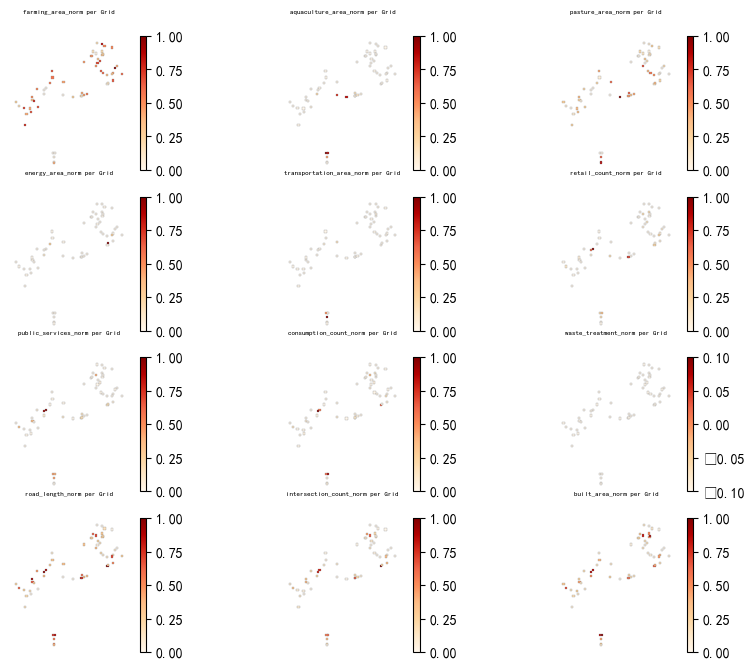

In [13]:
# 热力图

patches_map = gpd.read_file("processing_data\patch\patches_normalized_1000.geojson")

variables = ['farming_area_norm','aquaculture_area_norm',
       'pasture_area_norm', 'energy_area_norm', 'transportation_area_norm',
       'retail_count_norm', 'public_services_norm',
       'consumption_count_norm', 'waste_treatment_norm', 'road_length_norm',
       'intersection_count_norm','built_area_norm',
       'entropy_production', 'entropy_landuse']

fig, axs = plt.subplots(4,3, figsize=(10,8))
axs = axs.flatten()
for i, var in enumerate(variables):
    patches_map.plot(column=var, ax=axs[i], cmap='OrRd', legend=True, edgecolor='grey', linewidth=0.2)
    axs[i].set_title(f'{var} per Grid', fontsize=5)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

      farming_area_norm  aquaculture_area_norm  pasture_area_norm  \
0                   0.0                    0.0                0.0   
1                   0.0                    0.0                0.0   
2                   0.0                    0.0                0.0   
3                   0.0                    0.0                0.0   
4                   0.0                    0.0                0.0   
...                 ...                    ...                ...   
3871                0.0                    0.0                0.0   
3872                0.0                    0.0                0.0   
3873                0.0                    0.0                0.0   
3874                0.0                    0.0                0.0   
3875                0.0                    0.0                0.0   

      energy_area_norm  transportation_area_norm  retail_count_norm  \
0                  0.0                       0.0                0.0   
1                  0.0       

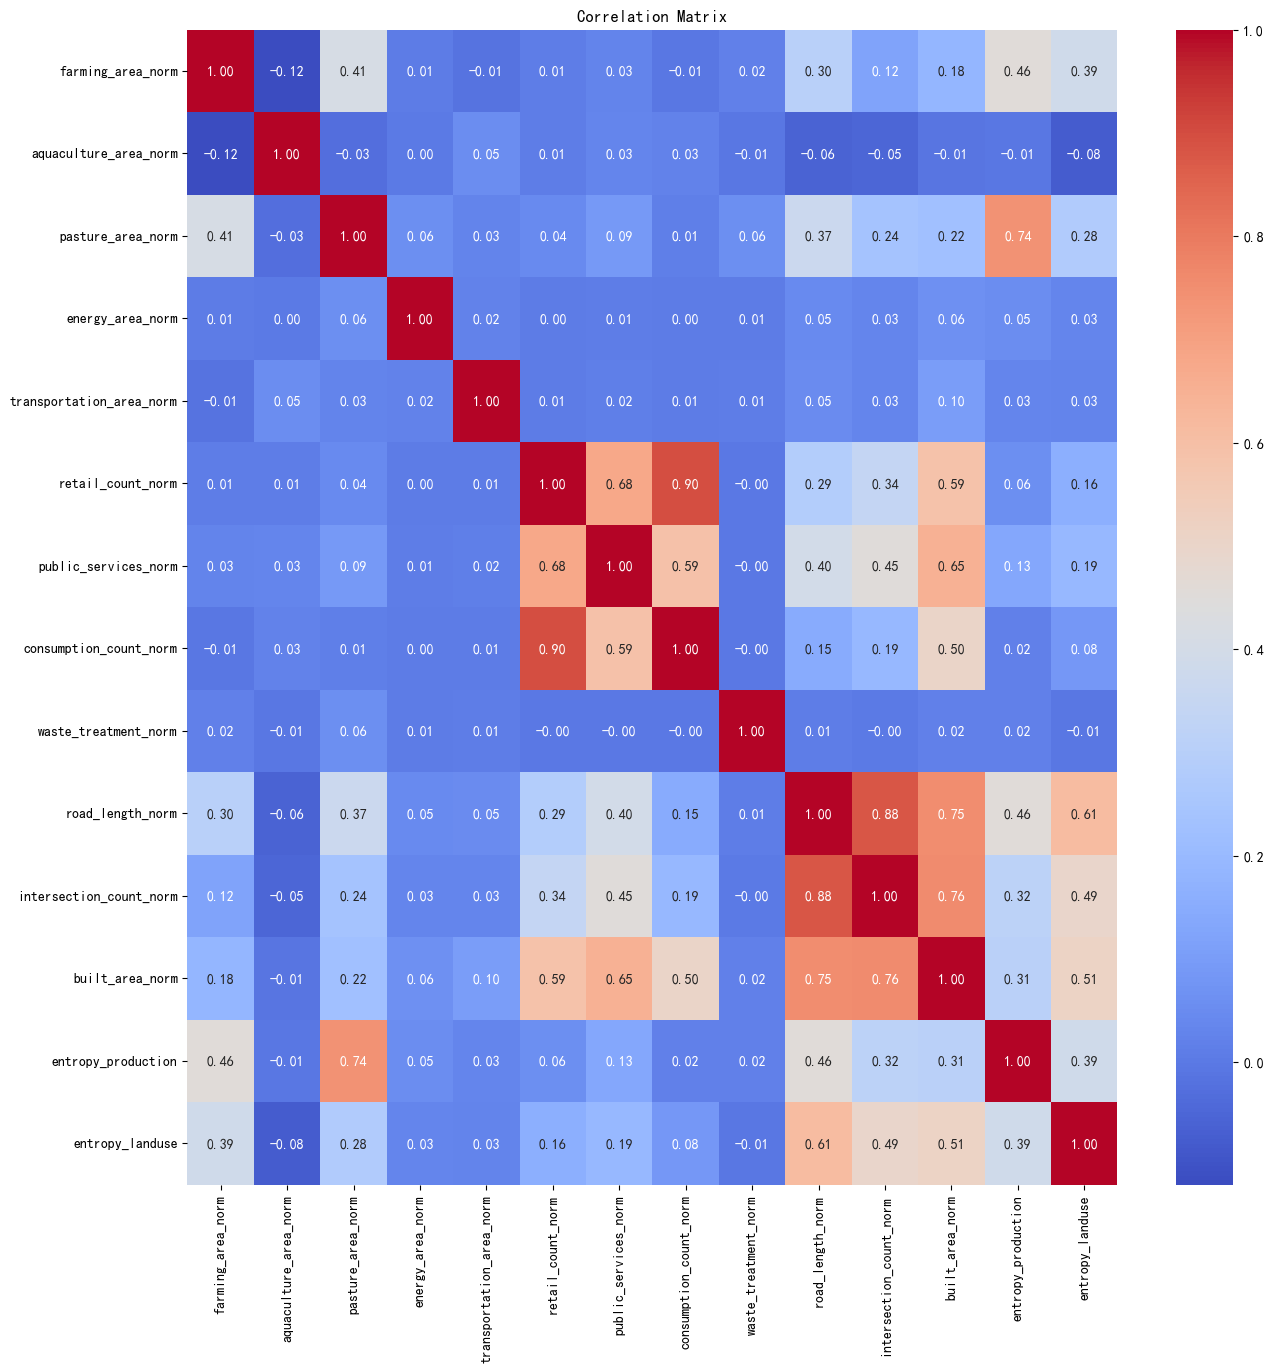

In [14]:
import seaborn as sns
import pandas as pd
patches = gpd.read_file("processing_data\grid\grid_normalized.geojson")

# 只提取需要分析的字段
df_analysis = patches[['farming_area_norm','aquaculture_area_norm',
       'pasture_area_norm', 'energy_area_norm', 'transportation_area_norm',
       'retail_count_norm', 'public_services_norm',
       'consumption_count_norm', 'waste_treatment_norm', 'road_length_norm',
       'intersection_count_norm','built_area_norm',
       'entropy_production', 'entropy_landuse']]
print(df_analysis)
# 计算相关性矩阵
corr_matrix = df_analysis.corr()
corr_matrix.to_csv("correlation_matrix.csv")
# 热力图可视化
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### 通过计算VIF排除共线性变量

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import numpy as np

# 标准化变量（非必须但推荐）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_analysis.dropna())  # 去除 NaN 影响

# 重新构建为 DataFrame
X_df = pd.DataFrame(X_scaled, columns=df_analysis.columns)

# 计算 VIF
vif_df = pd.DataFrame()
vif_df["Variable"] = X_df.columns
vif_df["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]

# vif_df.to_csv("vif_result.csv", index=False)
print(vif_df)

# 根据结论：
# consumption_count 与 retail_count，public_services， built_area
#

                    Variable       VIF
0          farming_area_norm  1.502820
1      aquaculture_area_norm  1.028929
2          pasture_area_norm  2.287177
3           energy_area_norm  1.010792
4   transportation_area_norm  1.030786
5          retail_count_norm  6.519733
6       public_services_norm  2.311633
7     consumption_count_norm  5.821326
8       waste_treatment_norm  1.007129
9           road_length_norm  6.720643
10   intersection_count_norm  5.644349
11           built_area_norm  4.673453
12        entropy_production  2.564118
13           entropy_landuse  1.810429


#  GWR分析
## 在进行分析之前，首先有OLS回归模型的分析

In [44]:
# patches = gpd.read_file("processing_data/patch/patches_normalized_1000.geojson")
patches = gpd.read_file("processing_data\grid\grid_normalized_3000.geojson")
print(patches.columns)

Index(['farming_area_norm', 'aquaculture_area_norm', 'pasture_area_norm',
       'energy_area_norm', 'transportation_area_norm', 'factory_count_norm',
       'retail_count_norm', 'public_services_norm', 'consumption_count_norm',
       'waste_treatment_norm', 'road_length_norm', 'intersection_count_norm',
       'built_area_norm', 'entropy_production', 'entropy_landuse', 'geometry'],
      dtype='object')


## 筛选有效网格进行分析

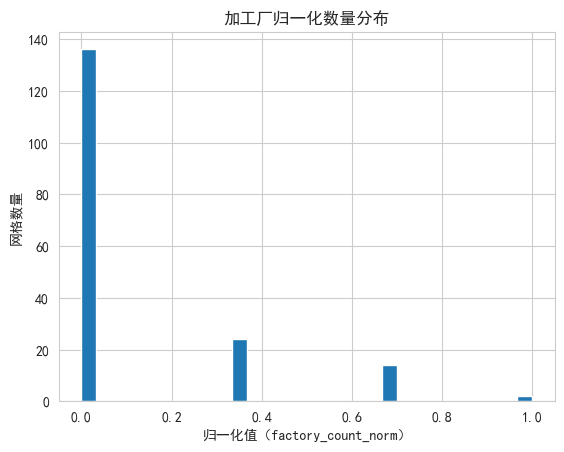

factory_count_norm
0.000000    0.772727
0.333333    0.136364
0.666667    0.079545
1.000000    0.011364
Name: proportion, dtype: float64


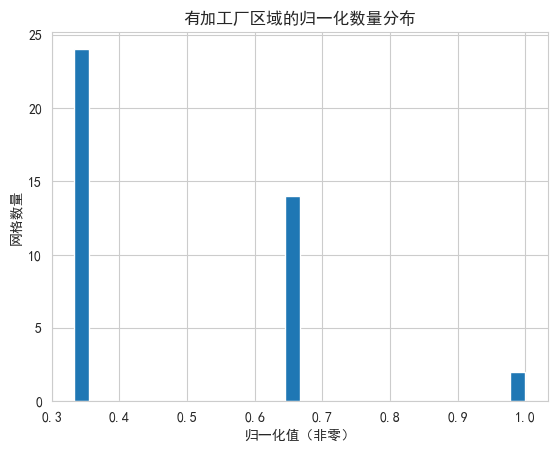

In [45]:
# 查看多少网格加工厂数量为零

import geopandas as gpd

patches = gpd.read_file("processing_data/grid/grid_normalized_3000.geojson")

import matplotlib.pyplot as plt

patches['factory_count_norm'].hist(bins=30)
plt.title('加工厂归一化数量分布')
plt.xlabel('归一化值（factory_count_norm）')
plt.ylabel('网格数量')
plt.grid(True)
plt.show()

# 查看不同值出现的频率（前10行）
value_counts = patches['factory_count_norm'].value_counts(normalize=True).sort_index()
print(value_counts.head(10))

non_zero = patches[patches['factory_count_norm'] > 0]
non_zero['factory_count_norm'].hist(bins=30)
plt.title('有加工厂区域的归一化数量分布')
plt.xlabel('归一化值（非零）')
plt.ylabel('网格数量')
plt.grid(True)
plt.show()


✅ 有效网格数量（包含工厂）: 55


C:\Users\Elena\AppData\Local\Temp\ipykernel_21876\1121913645.py:19: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_union = buffer.unary_union


✅ 缓冲区内总网格数量: 375


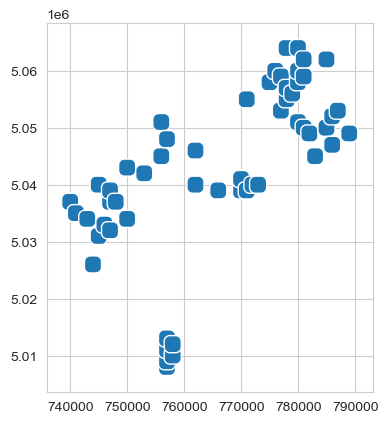

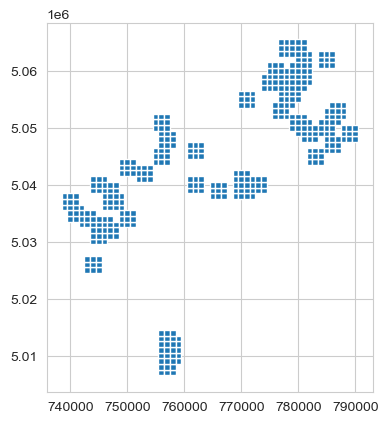

In [4]:
# 保留有工厂的/邻近的网格

import geopandas as gpd

patches = gpd.read_file("processing_data/grid/grid_normalized.geojson")

# 保留有工厂的网格（归一化值 > 0）
patches_with_factory = patches[patches['factory_count_norm'] > 0].copy()

# 保存以备检查
patches_with_factory.to_file("processing_data/grid/patches_with_factory_only.geojson")

print(f"✅ 有效网格数量（包含工厂）: {len(patches_with_factory)}")

# 创建 1000 米缓冲区
buffer = patches_with_factory.buffer(1000)
# 合并为一个大区块
buffer_union = buffer.unary_union

# 找出所有在缓冲区内的网格
patches_in_buffer = patches[patches.geometry.centroid.within(buffer_union)].copy()
# 保存结果
patches_in_buffer.to_file("processing_data/grid/patches_with_factory_and_neighbors.geojson")

print(f"✅ 缓冲区内总网格数量: {len(patches_in_buffer)}")



## 显著性检验（Moran’s I）是否有必要GWR

In [46]:
# 显著性检验（Moran’s I）：
#     GWR 前提是变量与目标之间在空间上存在“局部异质性”;
#     若 Moran’s I 显著为正 → 支持 GWR 合理性（如同 Chen 论文中残差的空间自相关检验）

from esda.moran import Moran
from libpysal.weights import KNN
patches= gpd.read_file("processing_data\grid\grid_normalized_3000.geojson")

w = KNN.from_dataframe(patches, k=8)
moran = Moran(patches['factory_count_norm'], w)
print(moran.I, moran.p_sim)

# 结果说明：Moran’s I正值，说明空间上存在轻度的正相关性（即“聚集”）
# p_sim=0.001，非常显著（p < 0.01），说明这种空间聚集并非偶然

# ✅ 结论
# 你当前的目标变量 factory_count_norm 在空间上具有显著的正向空间自相关性。
# ✅ 工厂数量在空间上“有聚集趋势”，而不是完全随机；
# ✅ 使用 地理加权回归（GWR）是合理且有必要的；
# ⚠️ 虽然整体聚集性不强（I ≈ 0.05），但显著性高，说明某些局部确实存在工厂聚集“热点区域”；
# ✅ GWR 正是为了揭示这种“不同地点影响因素不一样”的现象设计的。

0.12463987323537884 0.002


## OLS & GWR 建模

In [74]:
import geopandas as gpd
import pandas as pd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# === 1. 加载数据 ===
# patches = gpd.read_file("processing_data\grid\patches_with_factory_and_neighbors.geojson")
# patches= gpd.read_file("processing_data\grid\grid_normalized_3000.geojson")
# print(len(patches))

print(patches.columns)
# Index(['grid_id', 'farming_area_norm', 'aquaculture_area_norm',
#        'pasture_area_norm', 'energy_area_norm', 'transportation_area_norm',
#        'factory_count_norm', 'retail_count_norm', 'public_services_norm',
#        'consumption_count_norm', 'waste_treatment_norm', 'road_length_norm',
#        'intersection_count_norm', 'built_area_norm', 'entropy_production',
#        'entropy_landuse', 'geometry'],
#       dtype='object')
# === 2. 选择变量 & 去除共线变量 ===
selected_vars = ['farming_area_norm','aquaculture_area_norm','pasture_area_norm','energy_area_norm',
                 'transportation_area_norm','retail_count_norm','public_services_norm','waste_treatment_norm',
                 'road_length_norm','built_area_norm','entropy_production','entropy_landuse']
## 去掉了 'consumption_count_norm','intersection_count_norm'

# X_raw = patches[selected_vars].dropna()
# y = patches['factory_count_norm'].values.reshape(-1, 1) # 替换为你真实的目标变量列名
# # y = np.ones((X_raw.shape[0], 1))

X_raw = patches[selected_vars]
y_raw = patches['factory_count_norm']
print(len(X_raw ))
print(len(y_raw))
mask = X_raw.notnull().all(axis=1) & y_raw.notnull()
X_raw = X_raw[mask]
y_raw= y_raw[mask]
# print(len(y))

# === 3. 标准化变量（推荐） ===
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)
y = y_raw.values.reshape(-1, 1)

# === 4. OLS 回归 ===
X_ols = sm.add_constant(X)
ols_model = sm.OLS(y, X_ols).fit()
print("=== OLS 模型结果 ===")
print(ols_model.summary())

# === 5. GWR 准备坐标 ===
# coords = np.array([(geom.centroid.x, geom.centroid.y) for geom in patches.loc[X_raw.index].geometry])
# coords = np.array([[geom.x, geom.y] for geom in  patches.geometry.centroid])
coords = np.array([(geom.centroid.x, geom.centroid.y) for geom in patches.geometry])


# === 6. 选择最优带宽 ===
selector = Sel_BW(coords, y, X)
bw = selector.search(bw_min=2, bw_max=50)
print(f"✅ GWR 最优带宽: {bw}")


# === 7. 拟合 GWR 模型 ===
gwr_model = GWR(coords, y, X, bw)
gwr_results = gwr_model.fit()

# === 8. 输出比较指标 ===
print("\n=== 模型指标对比 ===")
print(f"GWR AICc : {gwr_results.aicc:.4f}")   # 改为小写 aicc
print(f"OLS AIC  : {ols_model.aic:.4f}")
print(f"GWR R2   : {gwr_results.R2:.4f}")
print(f"OLS R2   : {ols_model.rsquared:.4f}")


# === 9. 输出每个点的回归系数表 ===
beta_df = pd.DataFrame(gwr_results.params, columns=["Intercept"] + selected_vars)
beta_df["R2_local"] = gwr_results.localR2
beta_df.to_csv("gwr_coefficients.csv", index=False)

# === 10. 若需要合并到 GeoDataFrame 可视化 ===
patches_gwr = patches.loc[X_raw.index].copy()
for i, var in enumerate(["Intercept"] + selected_vars):
    patches_gwr[f'beta_{var}'] = gwr_results.params[:, i]
patches_gwr["R2_local"] = gwr_results.localR2
patches_gwr.to_file("patches_with_gwr.geojson", driver="GeoJSON")




Index(['farming_area_norm', 'aquaculture_area_norm', 'pasture_area_norm',
       'energy_area_norm', 'transportation_area_norm', 'factory_count_norm',
       'retail_count_norm', 'public_services_norm', 'consumption_count_norm',
       'waste_treatment_norm', 'road_length_norm', 'intersection_count_norm',
       'built_area_norm', 'entropy_production', 'entropy_landuse', 'geometry'],
      dtype='object')
176
176
=== OLS 模型结果 ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     7.168
Date:                Sun, 08 Jun 2025   Prob (F-statistic):           1.99e-10
Time:                        12:06:45   Log-Likelihood:                 51.533
No. Observations:                 176   AIC:                            -77.07
Df Residuals:

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

### 输出 OLS 标准化回归系数（SC）+ p值 + R²

In [62]:
# 输出 OLS 标准化回归系数（SC）+ p值 + R² 表格
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# 准备数据
X = X_raw.copy()
y = y_raw.copy()

# 标准化X和y
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1)).flatten()

# OLS模型拟合（标准化数据）
X_ols = sm.add_constant(X_scaled)
ols_model = sm.OLS(y_scaled, X_ols).fit()

# 输出标准化回归系数（SC）+ p值表格
sc_results = pd.DataFrame({
    'Variable': ['Intercept'] + list(X.columns),
    'Standardized Coef (SC)': ols_model.params,
    'p-value': ols_model.pvalues
})

# 添加Adjusted R² 到表格
adjusted_r2 = ols_model.rsquared_adj
sc_results['Adjusted R²'] = [adjusted_r2] + [''] * (len(sc_results)-1)

print("✅ OLS标准化回归系数（SC）+ p值 + Adjusted R² 结果表格:")
print(sc_results)

# 保存为CSV
sc_results.to_csv("ols_SC_pvalue_r2.csv", index=False)


✅ OLS标准化回归系数（SC）+ p值 + Adjusted R² 结果表格:
                    Variable  Standardized Coef (SC)   p-value Adjusted R²
0                  Intercept           -1.249001e-16  1.000000    0.297243
1          farming_area_norm            2.593973e-01  0.002992            
2      aquaculture_area_norm            8.782559e-02  0.261957            
3          pasture_area_norm           -7.117824e-02  0.452884            
4           energy_area_norm            3.513668e-02  0.703788            
5   transportation_area_norm           -9.788562e-02  0.253769            
6          retail_count_norm            1.206701e-01  0.566469            
7       public_services_norm           -3.597899e-01  0.111283            
8       waste_treatment_norm           -1.022416e-01  0.246044            
9           road_length_norm           -1.082177e-01  0.507719            
10           built_area_norm            6.761696e-01  0.000208            
11        entropy_production            3.466208e-02  0.701

### 自动变量组合筛选

In [63]:
# 自动进行变量组合筛选，并输出表现指标表格
import itertools
import warnings
warnings.filterwarnings('ignore')  # 抑制可能的警告

# 存储结果的DataFrame
comb_results = []

variables = X.columns.tolist()

# 遍历2到len(variables)个变量的所有组合
for r in range(2, len(variables)+1):
    for var_comb in itertools.combinations(variables, r):

        X_subset = X[list(var_comb)]

        # 标准化
        X_scaled_subset = scaler_X.fit_transform(X_subset)
        X_ols_subset = sm.add_constant(X_scaled_subset)

        # 拟合模型
        model_subset = sm.OLS(y_scaled, X_ols_subset).fit()

        # 存储组合的表现指标
        comb_results.append({
            'Variables': ', '.join(var_comb),
            'Adjusted R²': model_subset.rsquared_adj,
            'AIC': model_subset.aic
        })

# 创建DataFrame并排序
comb_results_df = pd.DataFrame(comb_results)
comb_results_df.sort_values(by='Adjusted R²', ascending=False, inplace=True)

# 打印并保存
print("✅ 自动变量组合筛选结果（前10个最佳组合）:")
print(comb_results_df.head(10))

comb_results_df.to_csv("variable_combination_results.csv", index=False)


✅ 自动变量组合筛选结果（前10个最佳组合）:
                                              Variables  Adjusted R²  \
3487  farming_area_norm, aquaculture_area_norm, tran...     0.309927   
2947  farming_area_norm, transportation_area_norm, p...     0.309423   
2612  farming_area_norm, aquaculture_area_norm, past...     0.309282   
1772  farming_area_norm, aquaculture_area_norm, publ...     0.309114   
2732  farming_area_norm, aquaculture_area_norm, reta...     0.308361   
1898  farming_area_norm, pasture_area_norm, public_s...     0.308007   
3398  farming_area_norm, aquaculture_area_norm, past...     0.307951   
3475  farming_area_norm, aquaculture_area_norm, tran...     0.307923   
2720  farming_area_norm, aquaculture_area_norm, tran...     0.307911   
2717  farming_area_norm, aquaculture_area_norm, tran...     0.307691   

             AIC  
3487  443.942356  
2947  443.121625  
2612  443.157654  
1772  442.244772  
2732  443.392170  
1898  442.526637  
3398  444.445638  
3475  444.452623  
2720  443.50

### 局部回归系数绘图

In [64]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 中文与负号支持
plt.rcParams['font.sans-serif'] = ['SimHei']      # 中文字体（黑体）
plt.rcParams['axes.unicode_minus'] = False        # 负号正常显示

# === 1. 准备变量名列表（含 Intercept）===
coeff_names = ["Intercept"] + list(X_raw.columns)

# === 2. 提取参与 GWR 的网格数据（排除 NaN）===
# patches_gwr = patches.loc[X_raw.index].copy()
print(len(patches_gwr))
# === 3. 写入 GWR 模型输出（系数）===
for i, var in enumerate(coeff_names):
    patches_gwr[f'beta_{var}'] = gwr_results.params[:, i]

# === 4. 写入局部 R² ===
patches_gwr["R2_local"] = gwr_results.localR2

# === 5. 定义绘图函数（每个变量独立色带、对称于0）===
def plot_gwr_result(gdf, column, title, cmap="coolwarm"):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    # 保持色带对称（中心为0）
    col_data = gdf[column]
    bound = max(abs(col_data.min()), abs(col_data.max()))
    ticks = np.linspace(-bound, bound, 5)

    gdf.plot(
        column=column,
        cmap=cmap,
        ax=ax,
        legend=True,
        vmin=-bound,
        vmax=bound,
        legend_kwds={
            'label': "GWR 回归系数",
            'shrink': 0.6,
            'ticks': ticks
        },
        edgecolor='grey',
        linewidth=0.2
    )

    ax.set_title(title)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# === 6. 批量绘制所有变量的局部系数热力图 ===
for var in X_raw.columns:
    plot_gwr_result(patches_gwr, f'beta_{var}', f"GWR β - {var}")

# === 7. 单独绘制局部 R² 图（不做对称处理）===
def plot_r2(gdf, column="R2_local"):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    gdf.plot(
        column=column,
        cmap="YlGnBu",
        legend=True,
        ax=ax,
        legend_kwds={'label': "GWR 局部 R$^2$", 'shrink': 0.6},
        edgecolor='grey',
        linewidth=0.2
    )
    ax.set_title("GWR 局部 R$^2$")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_r2(patches_gwr)


176


ValueError: Length of values (124) does not match length of index (176)

#### 局部回归系数绘图--保存图片

In [31]:
# 可编辑输出路径的 GWR 图像导出脚本
import os
import matplotlib.pyplot as plt
import numpy as np

# ✅ 👉 你只需修改这里：
output_path = r"G:\CODE\UrbanFood\processing_data\img"  # ← 修改为你希望的输出文件夹路径（如 "D:/GWR/图像/"）
image_format = "png"             # 可选："png"、"pdf"、"svg"
dpi = 300                        # 图像清晰度

# ✅ 执行导出函数
def export_gwr_maps(gdf, X_raw, output_dir, image_format="png", dpi=300):
    """
    批量导出 GWR 热力图（变量局部系数和局部 R²）到指定文件夹
    """
    os.makedirs(output_dir, exist_ok=True)
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False

    for var in X_raw.columns:
        column = f"beta_{var}"
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))

        bound = max(abs(gdf[column].min()), abs(gdf[column].max()))
        ticks = np.linspace(-bound, bound, 5)

        gdf.plot(
            column=column,
            cmap="coolwarm",
            ax=ax,
            legend=True,
            vmin=-bound,
            vmax=bound,
            legend_kwds={
                'label': "GWR 回归系数",
                'shrink': 0.6,
                'ticks': ticks
            },
            edgecolor='grey',
            linewidth=0.2
        )

        ax.set_title(f"GWR β - {var}")
        ax.axis('off')
        plt.tight_layout()

        filename = f"gwr_beta_{var}.{image_format}"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath, dpi=dpi)
        plt.close()

    # 保存局部 R² 图
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    gdf.plot(
        column="R2_local",
        cmap="YlGnBu",
        ax=ax,
        legend=True,
        legend_kwds={'label': "GWR 局部 R$^2$", 'shrink': 0.6},
        edgecolor='grey',
        linewidth=0.2
    )
    ax.set_title("GWR 局部 R$^2$")
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"gwr_R2_local.{image_format}"), dpi=dpi)
    plt.close()

    print(f"✅ 已成功导出 {len(X_raw.columns)+1} 张图像到：{output_dir}")

# ✅ 调用函数（路径来自你填写的 output_path）
export_gwr_maps(patches_gwr, X_raw, output_dir=output_path, image_format=image_format, dpi=dpi)


FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'G:\\'

### 新增功能：识别每个变量的显著性区域并绘图

In [32]:
#新增功能：识别每个变量的显著性区域并绘图；  判断每个网格中，变量 β 系数是否在统计上显著；
# 使用 95% 置信区间（±1.96 × 标准误）进行判断；
# 输出显著性类别：1 = 显著正向影响；-1 = 显著负向影响；0 = 不显著
# 自动绘图展示每个变量的空间显著性区域。
# === 8. 显著性区域识别与可视化 ===

def plot_significance_zones(gdf, gwr_results, variable_names, z=1.96):
    """
    识别每个变量在空间上的显著区域，并绘图（±z·SE）
    """
    beta = gwr_results.params
    se = gwr_results.bse

    for i, var in enumerate(variable_names):
        idx = i + 1  # 第0列为Intercept
        coef = beta[:, idx]
        stderr = se[:, idx]

        lower = coef - z * stderr
        upper = coef + z * stderr

        # 判断显著性
        sig = np.where(lower > 0, 1, np.where(upper < 0, -1, 0))
        sig_col = f"sig_{var}"
        gdf[sig_col] = sig

        # 绘图
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        cmap = plt.get_cmap("RdBu", 3)  # 红 = 正向显著, 蓝 = 负向显著, 灰 = 不显著
        gdf.plot(
    column=sig_col,
    cmap=cmap,
    ax=ax,
    legend=True,
    categorical=True,
    edgecolor='grey',
    linewidth=0.2,
    legend_kwds={
        'loc': 'upper left',           # 图例在左上角
        'bbox_to_anchor': (1.02, 1),   # 向右偏移图外
        'title': '显著性',              # 图例标题
        'fontsize': 10
    }
)

        
        ax.set_title(f"GWR 显著性区域 - {var}")
        ax.axis('off')
        plt.tight_layout()
        plt.show()

# === 调用：对所有变量绘制显著性图 ===
plot_significance_zones(patches_gwr, gwr_results, list(X_raw.columns))

# 🔴 红色：该变量在该网格 显著正向影响工厂数量；
# 🔵 蓝色：显著负向影响；
# ⚪ 灰色：影响不显著。

ValueError: Length of values (124) does not match length of index (176)